# 作业三：实战CNN —— CIFAR-10图像分类


| 姓名 | 学号 |
| :--: | :--: |
| 董林康 | 1120212477 |


### 要求：

<font color=Red>完成以下notebook，CIFAR数据集的下载和处理代码已经给出，请同学们自行完成训练过程。作业提交 jupyter notebook 文件。</font>

### 作业完成情况说明：

> 由于本作业测试模型过多(包括线性模型，LeNet，AlexNet，VGG16，做了数据增强的、没做数据增强的，在本地训练只用CPU训练的、在Colab上用Tesla T4训练的的等等)，因此将其分为notebook文件+压缩包的形式提交，notebook文件中包含每一个模型运行结果最好的代码及最后运行评估结果，而压缩包中包含了该项目中实际用到的所有`.ipynb`和`.py`文件。

在本次使用CNN进行CIFAR-10图像分类的任务中，我先后尝试了四个模型，包括三个CNN模型（LeNet,AlexNet,VGG16）和一个非CNN模型（线性分类器用于对比结果），本作业的对四个模型的训练和评估流程全部是采用先写一个小批量（或者小训练轮次）的数据集上先测试对比看一下模型训练效果，最后再选用最好的模型长时间训练、调参，最后在测试集上评估模型的效果。最后的达到的最好结果是采用了VGG16预训练模型的迁移学习的模型上，训练集准确率为0.89，测试集准确率为0.83（由于算力和时间原因限制了自己进一步训练，实际上模型依然没有出现overfit，准确率仍然可以提高）。

下面对作业过程进行简单的说明：

#### 无数据增强 + GPU训练 ： 线性分类器、LeNet、AlexNet

下面模型中前三个模型都是按照如下标准训练（采用的是本notebook的数据集下载方式）：

只使用train_data来训练和评估，kfold为7，激活函数为ReLU，损失函数为交叉熵，优化器为Adam，学习率为0.001，batch_size为128，训练轮数为10，在colab上的Tesla T4上训练。

结果如下表所示：


| 网络 | 训练集准确率 | 测试（验证）集准确率 | 评价 |
| --- | --- | --- | --- |
| LinearNet | 0.1 | 0.1 | 过于简单，无法拟合，最后loss不收敛，acc一直为0.1 |
| LeNet | 0.64 | 0.54 | 会有过拟合的现象产生，后面的话test_loss会开始上升，这里可能最好的准确率就在于0.54了 |
| AlexNet | 0.48 | 0.47 | 在前10个epoch中，test_loss和train_loss是在一直下降的，训练十轮下来的准确率虽然不如LeNet，但是也是可以接受的(进步空间比较大) |

其中对模型做解释如下：

- 最简单的Linear模型，即将图像展平后直接输入到全连接层，最后输出到10个类别的分类器中；只有两个隐含层，每个隐含层的神经元个数分别为1024和512，最后训练集准确率为0.1，测试集准确率为0.1。
- 针对CIFAR10数据集自己改进过后的LeNet模型（在最开始的卷积层做了一下改动，因为我们的shape是32*32），最后训练集准确率为0.64，测试集准确率为0.54。
- 也是针对CIFAR10数据集自己改进过后的AlexNet模型（同上），最后训练集准确率为0.48，测试集准确率为0.47。

其中我们对表现最优的AlexNet模型进行了进一步的训练，这里的训练就不使用kfold，而是直接使用train_data和train_labels来进行训练，使用test_data和test_labels来进行测试。我们每次只训练十轮，并输出看一下模型的准确率如何。训练及调参过程如下：

| epoch | train_acc | test_acc | 评价 |
| --- | --- | --- | --- |
| 10  | 0.62| 0.58| 看到train_loss和test_loss都在下降，继续训练|
| 20  | 0.66| 0.59| 看到train_loss和test_loss都在下降，继续训练|
| 30  | 0.71| 0.61| 看到train_loss和test_loss都在下降，继续训练|
| 40  | 0.66| 0.56| 不知道为什么这里出现了一次奇怪的波动（可能是colab上连接不稳定的问题）|
| 50  | 0.76| 0.59| train_loss开始反复波动了，这里结束后把学习率调小到1e-4|
| 60  | 0.90| 0.62| 这里看到的时候是很惊喜的，但训练集准确率上得那么快说明它可能也学不下去了|
| 70  | 0.94| 0.62| 测试集准确率上不去了|
| 80  | 0.95| 0.61| 测试集准确率上不去了|
| 90  | 0.96| 0.61| 测试集准确率上不去了|
| 100 | 0.97| 0.61| 测试集准确率上不去了|

我们在上面模型中得到的最优结果也只是0.62（测试集准确率），经过反思可能存在的问题后，所以下面的方法来进一步训练我们的CNN网络：

- 数据增强
- 加深网络

#### 数据增强 + GPU训练 ： 采用VGG16、ResNet18、ResNet50预训练模型的迁移学习

在这一部分中，我们自己重写了下载数据的方式，因为这样可以使用上transform来比较方便的进行自己的数据增强，我们使用了VGG16的预训练模型来进行迁移学习，具体过程就是利用VGG16在ImageNet上训练好的features层来为我们提取CIFAR10的特征，我们再重新定义并训练自己的线性分类器（固定特征层的参数），训练好之后再尝试进行微调特征层参数来更好的fit我们的模型（但最后微调失败了，因为后面的分类器没有足够的时间去训练好，导致较大误差传入前面的特征层处），在这一部分将测试集准确率提升到了83.44%。采取同样的方法，我们继续在ResNet18和ResNet50上进行迁移学习，最后在ResNet50冻结特征层、训练分类器，再微调特征层的参数的情况下，我们得到了最好的结果，即测试集准确率为90.09%（训练集准确率为95%，实际上我们可以进一步训练，但由于时间原因没有那么做）。


----------------------

## 作业内容如下



CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。

一共包含 10 个类别的 RGB 彩色图 片：飞机（ airlane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。

## 下载和缓存数据集

这里实现了几个函数来下载 CIFAR-10 数据集， CIFAR_URL是下载数据集的网址。

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time

CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

下面的`download`函数用来下载并解压缩数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中。
如果缓存目录中已经存在此数据集文件，并且其名称与下载文件名匹配，
我们将使用缓存的文件，以避免重复的下载。

下载完成后函数执行解压缩，为避免重复解压缩，同样检查是否有文件名相匹配。

In [5]:
def downloadCIFAR():
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dic')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')
        
downloadCIFAR()

CIFAR exist
unpacking CIFAR


## 数据处理

下面的代码用作处理数据。
 
CIFAR数据保存为 `pkl` 格式，需要加载 `pickle` 来读取文件，下面的 `unpickle` 函数实现了读取 `pkl` 文件并返回 `List` 的功能。

可以尝试展示一下读取的数据，下面的 `show_img` 函数实现了读取数据并展示图片和label的功能

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()


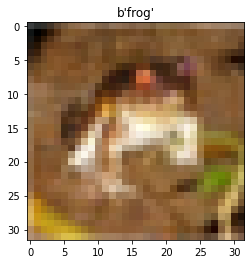

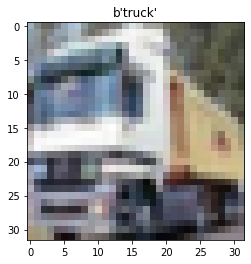

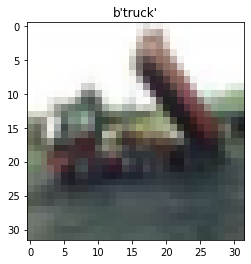

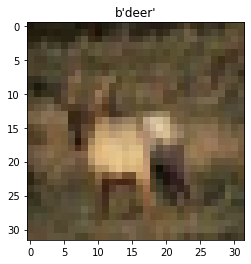

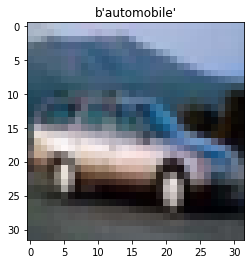

In [10]:
for i in range(5):
    show_img(i)

下面的代码实现了将读取到的数据转为torch.tensor以及一系列形状操作。

<font color=Red>完成作业时可以参考下面的代码，也可以自己实现相关功能。<font>

In [11]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


# <font color=Red>训练（自行完成）<font>

看到这里，请同学自己完成从**定义data loader、定义网络、定义损失函数、定义优化器到进行训练等一系列深度学习流水线**。
    
神经网络请使用 ***卷积神经网络*** ，可以使用现有论文模型，也可以自己提出改进或提出新模型。

不限制手写或使用 `torch.nn`等高级API，视手写代码占比有一定程度加分（最多加1分）。

> 下面代码均是在colab上运行过的

# 无数据增强 + GPU训练 ： 线性分类器、LeNet、AlexNet

In [ ]:
!nvidia-smi

Mon Apr 10 01:31:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 加载数据

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time

CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

def downloadCIFAR():
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dic')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')
        
downloadCIFAR()

make dic
downloading CIFAR
unpacking CIFAR


## 数据处理

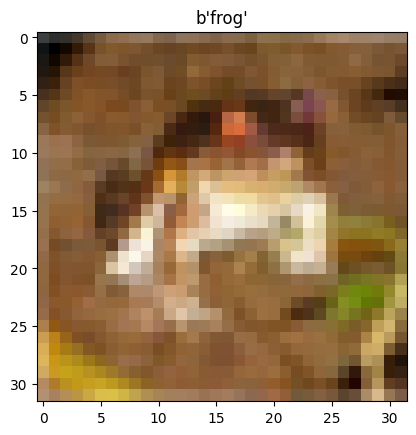

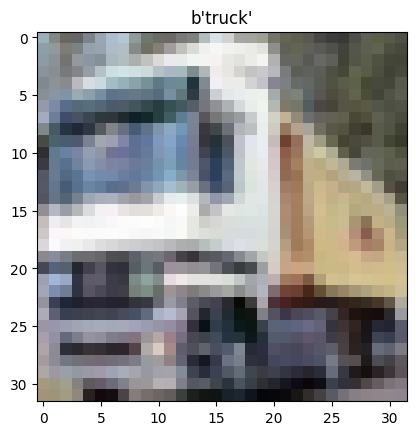

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()

for i in range(2):
    show_img(i)

In [ ]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


> 至此为止我们创建了一系列的数据，包括`train_labels, train_data, test_labels, test_data`，他们的形式都是tensor，下面我们将会用LeNet去简单测试一下

## 模型定义

In [ ]:
class LinearNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LinearNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2), # 10x3x32x32 -> 10x6x32x32
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2), # 10x6x32x32 -> 10x6x16x16
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), # 10x6x16x16 -> 10x16x12x12
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 10x16x12x12 -> 10x16x6x6
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(inplace=True), # inplace=True means that it will modify the input directly
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2), # 10x3x32x32 -> 10x64x17x17
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x64x17x17 -> 10x64x8x8
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2), #  10x64x8x8 -> 10x192x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x192x8x8 -> 10x192x3x3

            nn.Conv2d(192, 384, kernel_size=3, padding=1), # 10x192x3x3 -> 10x384x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 10x384x3x3 -> 10x256x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 10x256x3x3 -> 10x256x3x3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x256x3x3 -> 10x256x1x1
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
# model = LeNet()
# model = LinearNet()
model.to(device)
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [10, 10]                  --
├─Sequential: 1-1                        [10, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [10, 64, 17, 17]          1,792
│    └─ReLU: 2-2                         [10, 64, 17, 17]          --
│    └─MaxPool2d: 2-3                    [10, 64, 8, 8]            --
│    └─Conv2d: 2-4                       [10, 192, 8, 8]           307,392
│    └─ReLU: 2-5                         [10, 192, 8, 8]           --
│    └─MaxPool2d: 2-6                    [10, 192, 3, 3]           --
│    └─Conv2d: 2-7                       [10, 384, 3, 3]           663,936
│    └─ReLU: 2-8                         [10, 384, 3, 3]           --
│    └─Conv2d: 2-9                       [10, 256, 3, 3]           884,992
│    └─ReLU: 2-10                        [10, 256, 3, 3]           --
│    └─Conv2d: 2-11                      [10, 256, 3, 3]           

## 开始训练

### Trainer

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

class Trainer:
    def __init__(self, model, X, y, num_epochs, batch_size, loss_fn, optimizer, n_splits=5, is_print=True, print_every=10):
        self.train_losses_per_fold = [] # 记录每个fold的训练损失
        self.test_losses_per_fold = [] # 记录每个fold的测试损失
        self.mean_train_losses = np.zeros(num_epochs) # 记录每个epoch的平均训练损失
        self.mean_test_losses = np.zeros(num_epochs) # 记录每个epoch的平均测试损失
        
        self.model = model

        self.X = X
        self.y = y

        self.num_epochs = num_epochs
        self.batch_size = batch_size

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.n_splits = n_splits

        self.is_print = is_print
        self.print_every = print_every
        pass

    
    def reset_parameters(self, model):
        # 重置模型参数
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
                print("reset_parameters")

    def reset_model(self):
        # 重置模型参数为最开始初始化的参数
        self.model.load_state_dict(torch.load("model.pth"))

    def train_kfold(self):
        # 保存模型
        torch.save(self.model.state_dict(), "model.pth")

        kf = KFold(n_splits=self.n_splits) # 创建KFold对象

        # 开始交叉验证循环
        for fold_index, (train_index, test_index) in enumerate(kf.split(self.X)):
            if self.is_print:
                print(f"Fold {fold_index}")

            # self.model.apply(self.reset_parameters) # 重置模型参数为最开始初始化的参数
            self.reset_model() # 重置模型参数为最开始初始化的参数
                
            X_train = self.X[train_index] # 训练集特征
            y_train = self.y[train_index] # 训练集标签
            X_test = self.X[test_index] # 测试集特征
            y_test = self.y[test_index] # 测试集标签

            train_loss_history = [] # 记录训练损失
            test_loss_history = [] # 记录测试损失
            
            train_dataset = TensorDataset(X_train, y_train) # 创建训练集数据集对象
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size) # 创建训练集数据加载器对象
            
            test_dataset = TensorDataset(X_test, y_test) # 创建测试集数据集对象
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size) # 创建测试集数据加载器对象

            
            for epoch in range(self.num_epochs): # 训练num_epochs个周期

                train_loss = 0
                test_loss = 0

                self.model.eval() # 设置模型为评估模式
                
                with torch.no_grad(): 
                    
                    for batch_X, batch_y in test_loader: 
                        
                        output = self.model(batch_X).squeeze()
                        
                        loss = self.loss_fn(output, batch_y)

                        test_loss += loss.item() * batch_y.shape[0] # 记录测试损失
                
                
                self.model.train() # 设置模型为训练模式

                for batch_X, batch_y in train_loader: # 遍历训练集批次
                    
                    self.optimizer.zero_grad() # 清空梯度
                    
                    output = self.model(batch_X).squeeze() # 前向传播，得到输出
                    
                    loss = self.loss_fn(output, batch_y) # 计算损失
                    
                    loss.backward() # 反向传播，计算梯度
                    
                    self.optimizer.step() # 更新参数

                    train_loss += loss.item() * batch_y.shape[0] # 记录训练损失

                mean_train_loss = train_loss / X_train.shape[0] # 计算平均训练损失
                mean_test_loss = test_loss / X_test.shape[0]# 计算平均测试损失
                
                if self.is_print and (epoch+1) % self.print_every == 0: # 每print_every个周期打印一次训练信息(损失
                    print(f"Epoch | {epoch+1:2d}/{self.num_epochs:2d} | Train Loss: {mean_train_loss:.4f} | Test Loss: {mean_test_loss:.4f}")

                train_loss_history.append(mean_train_loss) # 记录训练损失
                test_loss_history.append(mean_test_loss) # 记录测试损失

            self.train_losses_per_fold.append(train_loss_history) # 记录每个fold的训练损失
            self.test_losses_per_fold.append(test_loss_history) # 记录每个fold的测试损失

        self.mean_train_losses = np.mean(np.array(self.train_losses_per_fold), axis=0)
        self.mean_test_losses = np.mean(np.array(self.test_losses_per_fold), axis=0)

    def train_normal(self):
        X_train = self.X # 训练集特征
        y_train = self.y # 训练集标签

        train_loss_history = [] # 记录训练损失
        
        train_dataset = TensorDataset(X_train, y_train) # 创建训练集数据集对象
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size) # 创建训练集数据加载器对象
                
        for epoch in range(self.num_epochs): # 训练num_epochs个周期

            train_loss = 0
            
            self.model.train() # 设置模型为训练模式

            for batch_X, batch_y in train_loader: # 遍历训练集批次
                
                self.optimizer.zero_grad() # 清空梯度
                
                output = self.model(batch_X).squeeze() # 前向传播，得到输出
                
                loss = self.loss_fn(output, batch_y) # 计算损失
                
                loss.backward() # 反向传播，计算梯度
                
                self.optimizer.step() # 更新参数

                train_loss += loss.item() * batch_y.shape[0] # 记录训练损失

            mean_train_loss = train_loss / X_train.shape[0] # 计算平均训练损失

            if self.is_print and (epoch+1) % self.print_every == 0: # 每print_every个周期打印一次训练信息(损失
                print(f"Epoch | {epoch+1:2d}/{self.num_epochs:2d} | Train Loss: {mean_train_loss:.4f} ")

            train_loss_history.append(mean_train_loss) # 记录训练损失

        self.train_losses_per_fold.append(train_loss_history) # 记录每个fold的训练损失
    
    def visualize_kfold(self,width=30, height=6):
        # 绘制训练损失和测试损失
        plt.figure(figsize=(width, height))
        for i in range(self.n_splits):
            plt.subplot(1, self.n_splits, i+1)
            plt.plot(self.train_losses_per_fold[i], label=f"Train Loss Fold {i+1}")
            plt.plot(self.test_losses_per_fold[i], label=f"Test Loss Fold {i+1}")
            plt.legend()
        plt.show()

    def plot_mean_loss(self, width=10, height=6):
        # 绘制平均训练损失和平均测试损失 (所有fold的平均)
        plt.figure(figsize=(width, height))
        plt.plot(self.mean_train_losses, label="Mean Train Loss")
        plt.plot(self.mean_test_losses, label="Mean Test Loss")
        plt.legend()
        plt.show()
    
    def visualize_normal(self,width=10, height=6):
        # 绘制训练损失
        plt.figure(figsize=(width, height))
        plt.plot(self.train_losses_per_fold[0], label=f"Train Loss")
        plt.legend()
        plt.show()

    def predict(self, test_X):
        self.model.eval()
        with torch.no_grad():
            output = self.model(test_X).squeeze() # .squeeze()将输出的形状从[batch_size, 1]转换为[batch_size]
            return output

### 训练

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(
    model.to(device), 
    train_data.to(device), 
    train_labels.to(device), 
    num_epochs=10, 
    batch_size=128, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    n_splits=7, 
    is_print=True, 
    print_every=1
)

In [ ]:
trainer.train_kfold()

Fold 0
Epoch |  1/10 | Train Loss: 2.0852 | Test Loss: 2.3510
Epoch |  2/10 | Train Loss: 1.6618 | Test Loss: 1.7732
Epoch |  3/10 | Train Loss: 1.4981 | Test Loss: 1.5459
Epoch |  4/10 | Train Loss: 1.4147 | Test Loss: 1.4242
Epoch |  5/10 | Train Loss: 1.3594 | Test Loss: 1.3628
Epoch |  6/10 | Train Loss: 1.3267 | Test Loss: 1.4763
Epoch |  7/10 | Train Loss: 1.2769 | Test Loss: 1.3445
Epoch |  8/10 | Train Loss: 1.2446 | Test Loss: 1.4000
Epoch |  9/10 | Train Loss: 1.2244 | Test Loss: 1.3140
Epoch | 10/10 | Train Loss: 1.2030 | Test Loss: 1.2775
Fold 1
Epoch |  1/10 | Train Loss: 2.5065 | Test Loss: 2.3550
Epoch |  2/10 | Train Loss: 1.7931 | Test Loss: 1.8643
Epoch |  3/10 | Train Loss: 1.6733 | Test Loss: 1.6828
Epoch |  4/10 | Train Loss: 1.6012 | Test Loss: 1.7178
Epoch |  5/10 | Train Loss: 1.5400 | Test Loss: 1.5860
Epoch |  6/10 | Train Loss: 1.4737 | Test Loss: 1.5393
Epoch |  7/10 | Train Loss: 1.4130 | Test Loss: 1.4243
Epoch |  8/10 | Train Loss: 1.3715 | Test Loss: 1.3

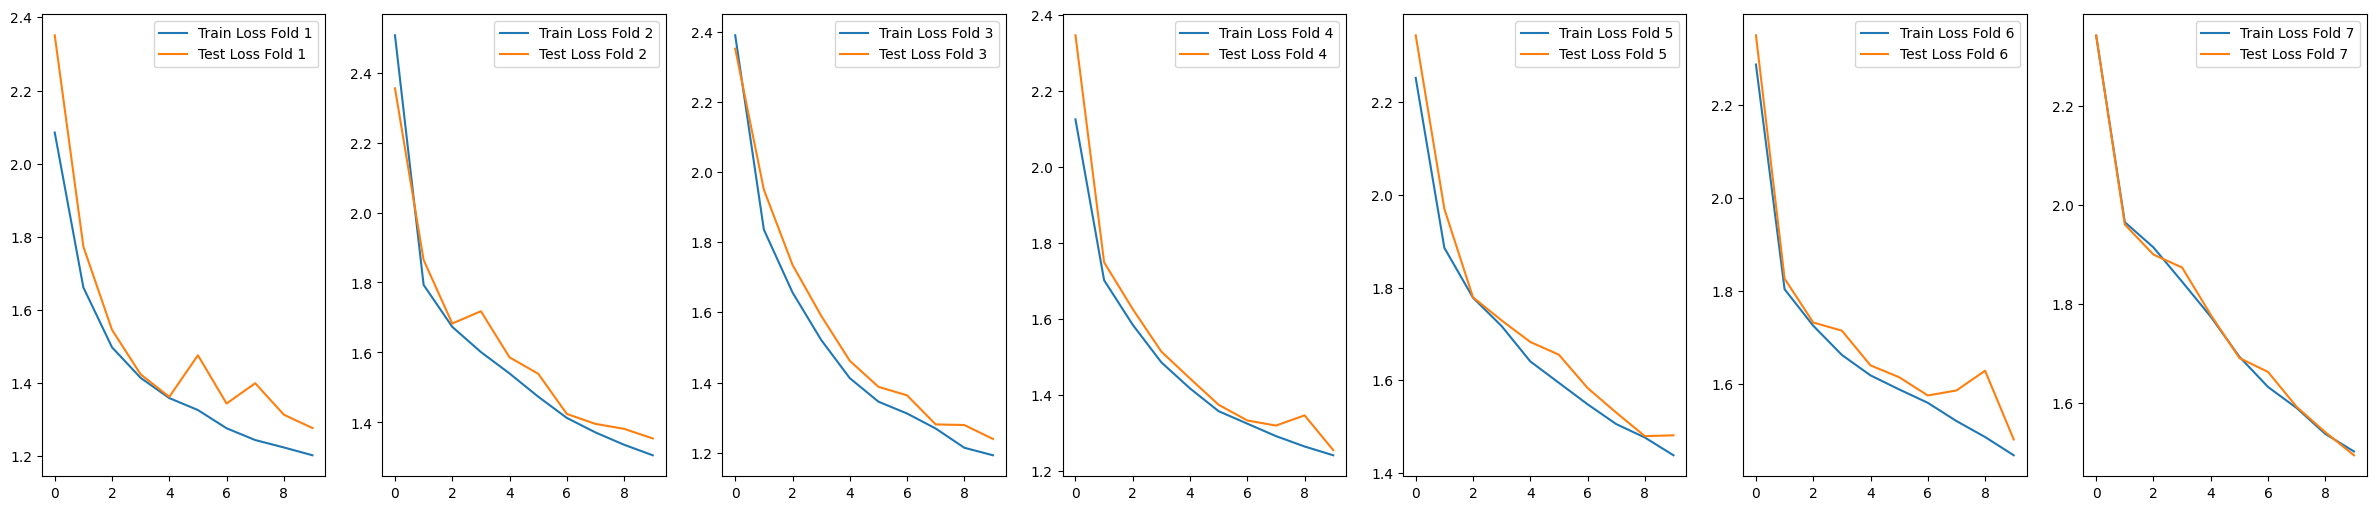

In [ ]:
trainer.visualize_kfold()

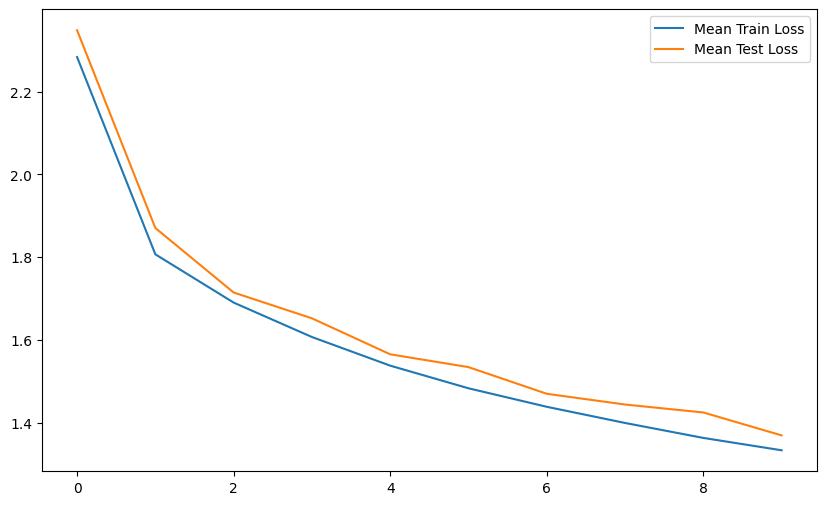

In [ ]:
trainer.plot_mean_loss(width=10, height=6)

## 评估

In [ ]:
def eval_train_and_test_acc():
  model.eval()

  with torch.no_grad():
      y_pred = model(train_data.to(device))
      y_pred = torch.softmax(y_pred, dim=1)  # dim=1表示对每一行进行softmax
      y_pred = torch.argmax(y_pred, dim=1)

      accuracy = torch.sum(y_pred == train_labels.to(device)).item() / len(train_labels)

  print(f"Train Accuracy: {accuracy:.2f}")

  with torch.no_grad():
      y_pred = model(test_data.to(device))
      y_pred = torch.softmax(y_pred, dim=1)
      y_pred = torch.argmax(y_pred, dim=1)

      accuracy = torch.sum(y_pred == test_labels.to(device)).item() / len(test_labels)

  print(f"Test Accuracy: {accuracy:.2f}")


eval_train_and_test_acc()

Train Accuracy: 0.10
Test Accuracy: 0.10


## 选定正确的model继续训练

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model.to(device)
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [10, 10]                  --
├─Sequential: 1-1                        [10, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [10, 64, 17, 17]          1,792
│    └─ReLU: 2-2                         [10, 64, 17, 17]          --
│    └─MaxPool2d: 2-3                    [10, 64, 8, 8]            --
│    └─Conv2d: 2-4                       [10, 192, 8, 8]           307,392
│    └─ReLU: 2-5                         [10, 192, 8, 8]           --
│    └─MaxPool2d: 2-6                    [10, 192, 3, 3]           --
│    └─Conv2d: 2-7                       [10, 384, 3, 3]           663,936
│    └─ReLU: 2-8                         [10, 384, 3, 3]           --
│    └─Conv2d: 2-9                       [10, 256, 3, 3]           884,992
│    └─ReLU: 2-10                        [10, 256, 3, 3]           --
│    └─Conv2d: 2-11                      [10, 256, 3, 3]           

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(
    model.to(device), 
    train_data.to(device), 
    train_labels.to(device), 
    num_epochs=10, 
    batch_size=128, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    n_splits=7, 
    is_print=True, 
    print_every=1
)

In [ ]:
trainer.train_normal()

Epoch |  1/10 | Train Loss: 2.0616 
Epoch |  2/10 | Train Loss: 1.5714 
Epoch |  3/10 | Train Loss: 1.4237 
Epoch |  4/10 | Train Loss: 1.3430 
Epoch |  5/10 | Train Loss: 1.2901 
Epoch |  6/10 | Train Loss: 1.2437 
Epoch |  7/10 | Train Loss: 1.2061 
Epoch |  8/10 | Train Loss: 1.1787 
Epoch |  9/10 | Train Loss: 1.1508 
Epoch | 10/10 | Train Loss: 1.1210 


In [ ]:
eval_train_and_test_acc()

Train Accuracy: 0.62
Test Accuracy: 0.58


In [ ]:
trainer.train_normal()
eval_train_and_test_acc()

Epoch |  1/10 | Train Loss: 0.7734 
Epoch |  2/10 | Train Loss: 0.7391 
Epoch |  3/10 | Train Loss: 0.7200 
Epoch |  4/10 | Train Loss: 0.7208 
Epoch |  5/10 | Train Loss: 0.7080 
Epoch |  6/10 | Train Loss: 0.7069 
Epoch |  7/10 | Train Loss: 0.6929 
Epoch |  8/10 | Train Loss: 0.6925 
Epoch |  9/10 | Train Loss: 0.7061 
Epoch | 10/10 | Train Loss: 0.7007 
Train Accuracy: 0.76
Test Accuracy: 0.59


In [ ]:
# 重新设定学习率，可以以后再想一下
trainer.optimizer.param_groups[0]['lr'] = 1e-4

In [ ]:
trainer.train_normal()
eval_train_and_test_acc()

Epoch |  1/10 | Train Loss: 0.1083 
Epoch |  2/10 | Train Loss: 0.1074 
Epoch |  3/10 | Train Loss: 0.1041 
Epoch |  4/10 | Train Loss: 0.0986 
Epoch |  5/10 | Train Loss: 0.0944 
Epoch |  6/10 | Train Loss: 0.0958 
Epoch |  7/10 | Train Loss: 0.0950 
Epoch |  8/10 | Train Loss: 0.0923 
Epoch |  9/10 | Train Loss: 0.0888 
Epoch | 10/10 | Train Loss: 0.0840 
Train Accuracy: 0.97
Test Accuracy: 0.61


> 在这个文件中我们测试了前面定义的三个网络放在colab上用Tesla T4跑，就是LinearNet，LeNet，AlexNet，在num_epochs = 10, batch_size = 128, learning_rate(Adam) = 0.001, kfold = 7的情况下我们比较了这三个模型的训练过程中的现象以及最后的测试集和训练集的准确率。
> 我们可以从下面的数据中看出对比所在：


| 网络 | 训练集准确率 | 测试集准确率 | 评价 |
| --- | --- | --- | --- |
| LinearNet | 0.1 | 0.1 | 过于简单，无法拟合，最后loss不收敛，acc一直为0.1 |
| LeNet | 0.64 | 0.54 | 会有过拟合的现象产生，后面的话test_loss会开始上升，这里可能最好的准确率就在于0.54了 |
| AlexNet | 0.48 | 0.47 | 在前10个epoch中，test_loss和train_loss是在一直下降的，训练十轮下来的准确率虽然不如LeNet，但是也是可以接受的(进步空间比较大) |

后面我们就一直使用AlexNet来进行训练，这里的训练就不使用kfold，而是直接使用train_data和train_labels来进行训练，使用test_data和test_labels来进行测试。我们每次只训练十轮，并输出看一下模型的准确率如何。训练过程如下：

| epoch | train_acc | test_acc | 评价 |
| --- | --- | --- | --- |
| 10  | 0.62| 0.58| 看到train_loss和test_loss都在下降，继续训练|
| 20  | 0.66| 0.59| 看到train_loss和test_loss都在下降，继续训练|
| 30  | 0.71| 0.61| 看到train_loss和test_loss都在下降，继续训练|
| 40  | 0.66| 0.56| 不知道为什么这里出现了一次奇怪的波动（可能是colab上连接不稳定的问题）|
| 50  | 0.76| 0.59| train_loss开始反复波动了，这里结束后把学习率调小到1e-4|
| 60  | 0.90| 0.62| 这里看到的时候是很惊喜的，但训练集准确率上得那么快说明它可能也学不下去了|
| 70  | 0.94| 0.62| 测试集准确率上不去了|
| 80  | 0.95| 0.61| 测试集准确率上不去了|
| 90  | 0.96| 0.61| 测试集准确率上不去了|
| 100 | 0.97| 0.61| 测试集准确率上不去了|

> 最后的train_loss在0.144

但总体来说我们发现10 epoch和90 epoch的差别真的是不大，所以感觉这里做一个10 epoch的小demo看一下优越性就很好了。

In [ ]:
!nvidia-smi

Sat Apr 15 07:46:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 数据增强 + GPU训练 ： 采用VGG16，ResNet18，ResNet50预训练模型的迁移学习

这个部分我们发现前面用的AlexNet抑或是LeNet这些传统的CNN网络都没有得到一个很好的训练结果，所以我们决定试一下迁移学习，看一下CIFAR10数据集上的VGG16，ResNet18，ResNet50网络预训练模型加持的效果会是怎么样。

## 加载数据

这里用到了数据增强，对数据进行了随机裁剪，随机翻转，还有归一化的操作。

需要注意的是预训练的VGG16网络需要的输入是224x224的图片，所以我们在这里对图片进行了缩放。而且我们认为一定程度上数据的类别在中心位置更加重要，所以我们在这里对图片进行了中心裁剪。



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义 transform，包括缩放、中心裁剪、随机水平翻转、归一化
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# 只需要归一化和中心裁剪
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载 CIFAR10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13152109.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


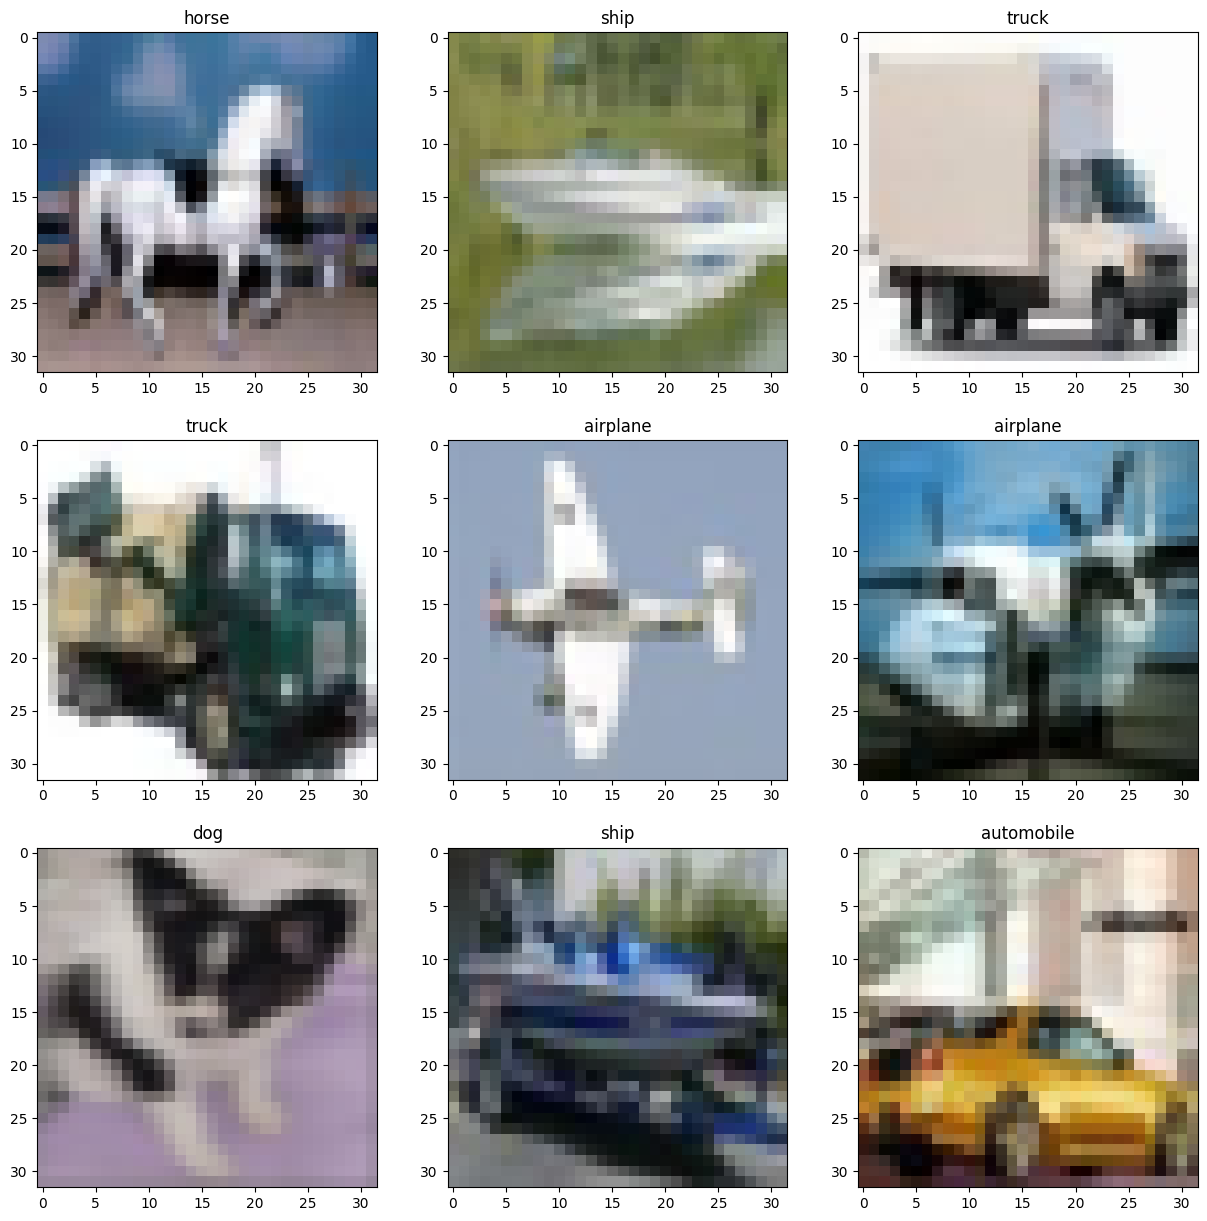

In [ ]:
def display(dataset = trainset):
    # 展示一下数据集
    import matplotlib.pyplot as plt
    import numpy as np

    indexs = np.random.randint(0, len(dataset), 9)

    imgs = [dataset.data[i] for i in indexs]
    labels = [dataset.targets[i] for i in indexs]
    classes = dataset.classes

    fig = plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(imgs[i])
        ax.set_title(classes[labels[i]])

display()

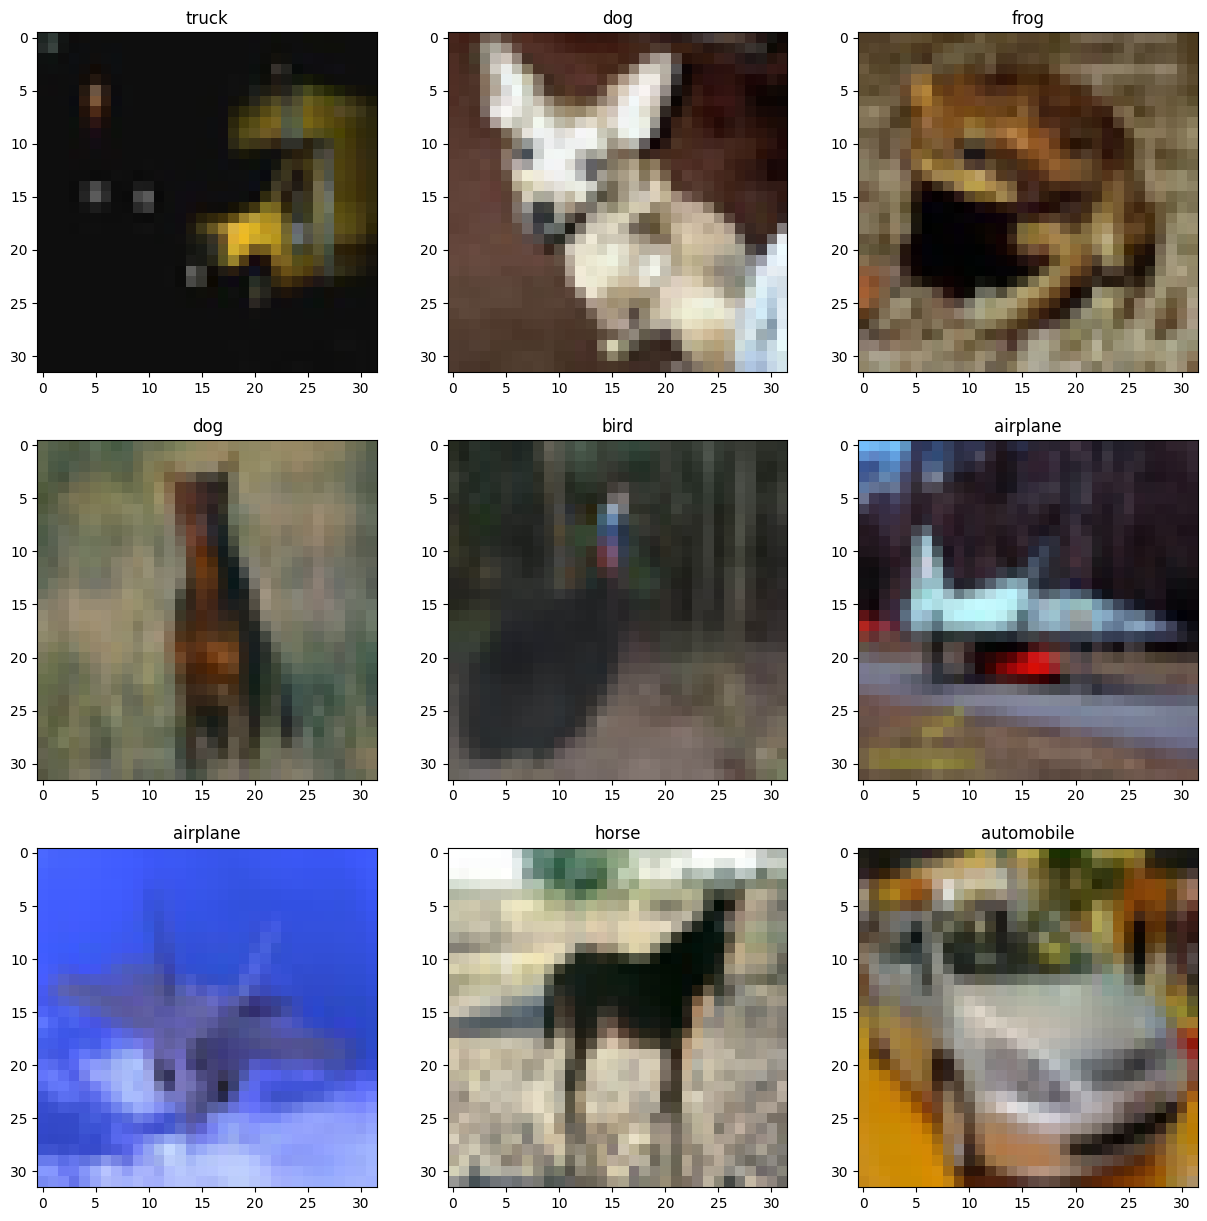

In [ ]:
display(testset)

## 加载预训练模型

In [ ]:
## 加载预训练模型VGG16
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# 加载预训练模型
net = models.vgg16(weights=models.VGG16_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 295MB/s]


In [ ]:
# 用原始的 VGG16 模型进行预测看一下分类出的是哪一类
with torch.no_grad():
    sample_image = trainset[0][0].unsqueeze(0)
    res = net(sample_image)
    print(res[0].argmax())
    print(trainset.classes[trainset[0][1]])
    

tensor(926)
frog


> 我们在 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a 网站上看到了103类是鸭嘴兽，但实际上是青蛙

## 查看模型架构

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
summary(net, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([1, 512, 7, 7])


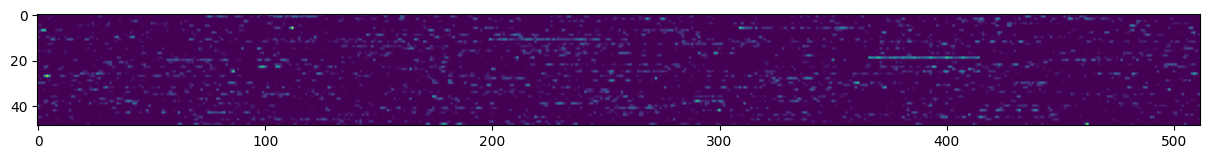

In [ ]:
## 查看模型提取的特征
import matplotlib.pyplot as plt
with torch.no_grad():        
    res = net.features(sample_image.to(torch.device(device))).cpu()
    plt.figure(figsize=(15, 3))
    plt.imshow(res.detach().view(-1,512))
    print(res.size())

## 先用一个小demo试一下

我们在VGG16预训练模型已经提取了很多特征了，现在我们在不知道VGG16对CIFAR10的分类效果如何的情况下，我们先用一个小的demo来看一下VGG16的效果。

我们的想法是先取800个的数据出来提取feature，然后用这些feature来训练一个分类器，看看这个分类器的效果如何。

In [ ]:
batch_size = 8
train_size = batch_size * 100 # 先用 800 个训练样本练一下看看
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

feature_tensor = torch.zeros((train_size, 512*7*7)).to(device)
label_tensor = torch.zeros((train_size)).to(device)

sample_cnt = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    with torch.no_grad():
        features = net.features(inputs.to(device))
        features = features.view(features.size(0), -1)
        feature_tensor[sample_cnt:sample_cnt+batch_size] = features
        label_tensor[sample_cnt:sample_cnt+batch_size] = labels
        sample_cnt += batch_size
        print('.',end='')
    if sample_cnt >= train_size:
        break


....................................................................................................

In [ ]:
feature_tensor.shape, label_tensor.shape

(torch.Size([800, 25088]), torch.Size([800]))

### 写一个小的线性层训练一下

In [ ]:
### 下面训练和验证的代码部分参考了微软家的pytorch教程
# https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/6-transfer-learning
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(device)
        out = net(features.to(device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(device)
            out = net(features.to(device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res


交叉熵函数

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
          l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
          \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

trainloader = torch.utils.data.DataLoader(train_ds,batch_size=32)
testloader = torch.utils.data.DataLoader(test_ds,batch_size=32)

classifier = torch.nn.Linear(512*7*7,10).to(device) # 10 个分类 最简单的线性分类器
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(classifier.parameters(),lr=0.001) # 使用 Adam 优化器

In [ ]:
history = train(classifier,trainloader,testloader,optimizer=optimizer,epochs=10,loss_fn=loss_fn)

Epoch  0, Train acc=0.550, Val acc=0.770, Train loss=0.041, Val loss=0.025
Epoch  1, Train acc=0.989, Val acc=0.720, Train loss=0.001, Val loss=0.025
Epoch  2, Train acc=0.993, Val acc=0.740, Train loss=0.001, Val loss=0.025
Epoch  3, Train acc=1.000, Val acc=0.720, Train loss=0.000, Val loss=0.022
Epoch  4, Train acc=1.000, Val acc=0.750, Train loss=0.000, Val loss=0.020
Epoch  5, Train acc=1.000, Val acc=0.740, Train loss=0.000, Val loss=0.020
Epoch  6, Train acc=1.000, Val acc=0.740, Train loss=0.000, Val loss=0.020
Epoch  7, Train acc=1.000, Val acc=0.740, Train loss=0.000, Val loss=0.020
Epoch  8, Train acc=1.000, Val acc=0.750, Train loss=0.000, Val loss=0.020
Epoch  9, Train acc=1.000, Val acc=0.750, Train loss=0.000, Val loss=0.020


> 这里我们用了800个数据就可以训练出78%的准确率，这个结果还是比较不错的（至少比之前辛辛苦苦的AlexNet达到的75%要好了），但是我们还是想看看完整VGG16的效果。
> 一是说明VGG16的特征提取能力很强，二也可能一部分原因在于我们做数据增强做的不错。

## 迁移学习

这一部分我们要做几件事：
- **替换最终的分类器**
- **冻结卷积特征提取器的权重**
- **微调**，fine-tuning~

### 冻结卷积特征提取器的权重

在下面这个cell的输出可以看到可以训练的参数小了很多。

In [ ]:
net.classifier = torch.nn.Linear(25088,10).to(device)

for x in net.features.parameters():
    x.requires_grad = False

summary(net,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [ ]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(device)
            optimizer.zero_grad()
            out = net(features.to(device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,shuffle=False, num_workers=2)

train_long(net,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=2,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.1171875, train loss = 0.018301717936992645
Epoch 0, minibatch 90: train acc = 0.7340315934065934, train loss = 0.027695980700817736
Epoch 0, minibatch 180: train acc = 0.7564312845303868, train loss = 0.02685552407364819
Epoch 0, minibatch 270: train acc = 0.7715924815498155, train loss = 0.02701200154434711
Epoch 0, minibatch 360: train acc = 0.7817693905817175, train loss = 0.027397710530711675
Epoch 0 done, validation acc = 0.7974, validation loss = 0.03536582946777344
Epoch 1, minibatch 0: train acc = 0.90625, train loss = 0.013116860762238503
Epoch 1, minibatch 90: train acc = 0.8638392857142857, train loss = 0.018950564520699636
Epoch 1, minibatch 180: train acc = 0.8634323204419889, train loss = 0.020021563735456098
Epoch 1, minibatch 270: train acc = 0.8628055811808119, train loss = 0.02074060932736555
Epoch 1, minibatch 360: train acc = 0.8611712257617729, train loss = 0.02190468648133846
Epoch 1 done, validation acc = 0.8306, validation los

In [ ]:
torch.save(net,'data/vgg_cifar10.pth')

In [ ]:
train_long(net,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=2,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.859375, train loss = 0.017761697992682457
Epoch 0, minibatch 90: train acc = 0.8844436813186813, train loss = 0.01972628032768166
Epoch 0, minibatch 180: train acc = 0.8827693370165746, train loss = 0.021135720100192074
Epoch 0, minibatch 270: train acc = 0.8807656826568265, train loss = 0.02181015683276187
Epoch 0, minibatch 360: train acc = 0.8798692867036011, train loss = 0.02215972699617085
Epoch 0 done, validation acc = 0.8179, validation loss = 0.04933550720214844
Epoch 1, minibatch 0: train acc = 0.8984375, train loss = 0.02472298964858055
Epoch 1, minibatch 90: train acc = 0.8993818681318682, train loss = 0.01828101572099623
Epoch 1, minibatch 180: train acc = 0.901976864640884, train loss = 0.017707154237104384
Epoch 1, minibatch 270: train acc = 0.8999077490774908, train loss = 0.018888939790620136
Epoch 1, minibatch 360: train acc = 0.8992382271468145, train loss = 0.019353891673840974
Epoch 1 done, validation acc = 0.8344, validation loss

In [ ]:
torch.save(net,'data/vgg_cifar10_epoch4.pth')

### fine-tuning~😢



In [ ]:
# 先用两个epoch的参数训练一下试试先
net = torch.load('data/vgg_cifar10.pth')

In [ ]:
summary(net,(1, 3,244,244))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [ ]:
for x in net.features.parameters():
    x.requires_grad = True

In [ ]:
summary(net,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         1,792
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         36,928
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        73,856
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        147,584
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]          29

In [ ]:
train_long(net,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=2,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.9453125, train loss = 0.011909919790923595
Epoch 0, minibatch 90: train acc = 0.1095467032967033, train loss = 233007.45054945056


KeyboardInterrupt: ignored

> 微调失败，train_loss我们可以看到飙升到很高的位置，不能再继续做跑下去了，但幸好是保存了微调之前的参数

## 最终结果

In [ ]:
# 重新加载两个epoch的参数
net = torch.load('data/vgg_cifar10.pth')

In [ ]:
validate(net,testloader,loss_fn=torch.nn.CrossEntropyLoss())

(0.034634646606445316, 0.8306)

最后达到83%的准确率个人感觉很不错了已经😢😢😢😢😢

In [ ]:
# 重新加载训练了四个epoch的参数
net = torch.load('data/vgg_cifar10_epoch4.pth')

In [ ]:
validate(net,testloader,loss_fn=torch.nn.CrossEntropyLoss())

(0.04636558837890625, 0.8344)

In [ ]:
!nvidia-smi

Mon Apr 17 07:21:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ResNet

到最后了还是忍不住想用ResNet试一下，因为ResNet给人的美感太强了，虽然自己已经交作业了，不过还是很想看看ResNet的效果。这个notebook估计自己想这样做，先自己从头训练一下看看效果，再用预训练的模型试一下。

## 从头开始的ResNet

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

### 定义残差块

这里借鉴了李沐老师的动手学习深度学习的代码，架构如下：

![resnet](resnet-block.svg)


In [ ]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

#### 残差块小测试

我们测试一下输入输出的维度是怎么样的：

In [ ]:
X = torch.rand((4, 3, 6, 6))
resBlock = Residual(3, 3)
resBlock(X).shape # torch.Size([4, 3, 6, 6]) # same shape

torch.Size([4, 3, 6, 6])

In [ ]:
resBlock = Residual(3, 6, use_1x1conv=True, strides=2)
resBlock(X).shape # torch.Size([4, 6, 3, 3]) # 1/2 shape

torch.Size([4, 6, 3, 3])

复习一下`nn.Conv2d`的输入输出大小计算公式

$$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$

$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor 
$$

$$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$$

In [ ]:
nn.Conv2d(3, 3, kernel_size=3, padding=1, stride=1)(X).shape # torch.Size([4, 3, 6, 6]) # same shape

torch.Size([4, 3, 6, 6])

In [ ]:
nn.Conv2d(3, 3, kernel_size=3, padding=1, stride=2)(X).shape # torch.Size([4, 3, 3, 3]) # 1/2 shape

torch.Size([4, 3, 3, 3])

### 定义ResNet的block

ResNet在第一个block的时候是和谷歌的Inception是一样的，不同的是ResNet在卷积层之后加了一个BatchNorm层。

In [ ]:
block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                          nn.BatchNorm2d(64), nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
X = torch.rand((4, 3, 224, 224))
block1(X).shape # torch.Size([4, 64, 56, 56])

torch.Size([4, 64, 56, 56])

In [ ]:
# 定义除了block1之外的block网络结构
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [ ]:
# 接着在ResNet加入所有残差块，这里每个模块使用2个残差块。这样我们下面每个模块就有4个卷积层，下面就一共16个卷积层
block2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
block3 = nn.Sequential(*resnet_block(64, 128, 2))
block4 = nn.Sequential(*resnet_block(128, 256, 2))
block5 = nn.Sequential(*resnet_block(256, 512, 2))

#### 残差block小测试

In [ ]:
X = torch.rand((4, 64, 56, 56))
block2(X).shape # torch.Size([4, 64, 56, 56])

torch.Size([4, 64, 56, 56])

In [ ]:
block3(X).shape # torch.Size([4, 128, 28, 28])

torch.Size([4, 128, 28, 28])

In [ ]:
X = torch.rand((4, 128, 28, 28))
block4(X).shape # torch.Size([4, 256, 14, 14])

torch.Size([4, 256, 14, 14])

In [ ]:
X = torch.rand((4, 256, 14, 14))
block5(X).shape # torch.Size([4, 512, 7, 7])

torch.Size([4, 512, 7, 7])

In [ ]:
X = torch.rand((4, 512, 7, 7))
nn.AdaptiveAvgPool2d((1, 1))(X).shape # torch.Size([4, 512, 1, 1])

torch.Size([4, 512, 1, 1])

### 定义ResNet18

In [ ]:
ResNet18 = nn.Sequential(block1, block2, block3, block4, block5,
                          nn.AdaptiveAvgPool2d((1, 1)),
                            nn.Flatten(),
                            nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in ResNet18:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
from torchinfo import summary
summary(ResNet18, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Residual: 2-5                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─Residual: 2-6                     [1, 64, 56, 56]           --
│

## 训练过程

In [ ]:
learning_rate = 0.001
batch_size = 128
num_epochs = 5

### 加载数据集及可视化

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义 transform，包括缩放、中心裁剪、随机水平翻转、归一化
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# 只需要归一化和中心裁剪
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载 CIFAR10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


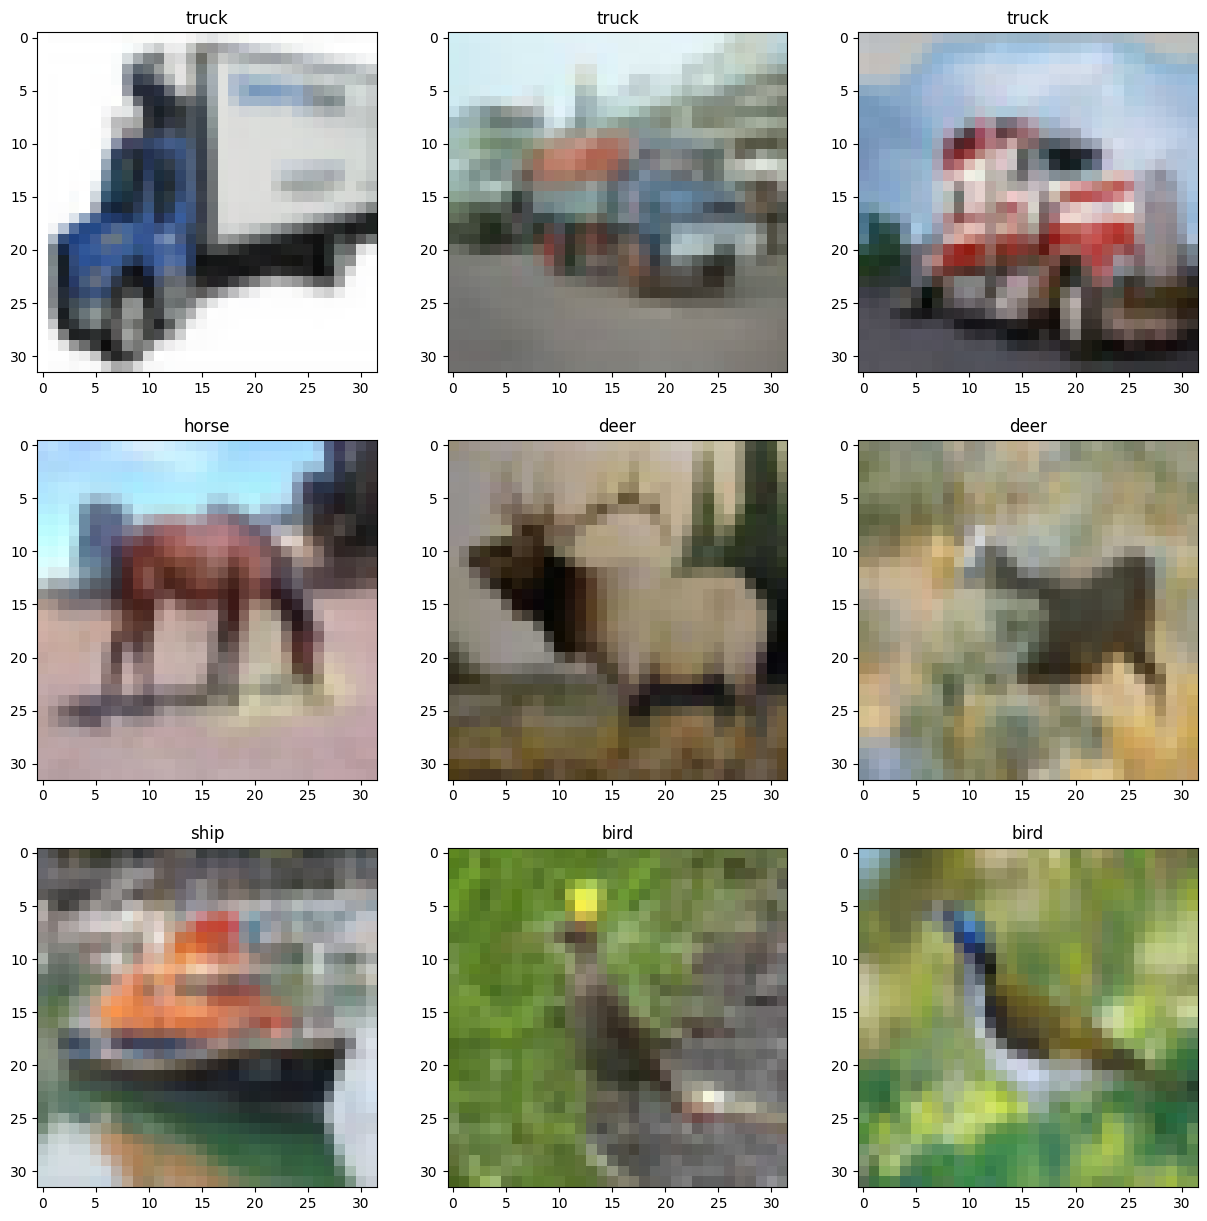

In [ ]:
def display(dataset = trainset):
    # 展示一下数据集
    import matplotlib.pyplot as plt
    import numpy as np

    indexs = np.random.randint(0, len(dataset), 9)

    imgs = [dataset.data[i] for i in indexs]
    labels = [dataset.targets[i] for i in indexs]
    classes = dataset.classes

    fig = plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(imgs[i])
        ax.set_title(classes[labels[i]])

display()

### 定义训练函数

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 下面训练和验证的代码部分参考了微软家的pytorch教程
# https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/6-transfer-learning
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(device)
        out = net(features.to(device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(device)
            out = net(features.to(device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [ ]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(device)
            optimizer.zero_grad()
            out = net(features.to(device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

In [ ]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=0.01) # 使用 Adam 优化器
epochs = 10
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(ResNet18,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=epochs,print_freq=50)

Epoch 0, minibatch 0: train acc = 0.1015625, train loss = 0.00915361475199461
Epoch 0, minibatch 50: train acc = 0.14736519607843138, train loss = 0.009552977833093381
Epoch 0, minibatch 100: train acc = 0.1975943688118812, train loss = 0.00863521405965975
Epoch 0, minibatch 150: train acc = 0.23828125, train loss = 0.008086427947543315
Epoch 0 done, validation acc = 0.3742, validation loss = 0.006700816345214844
Epoch 1, minibatch 0: train acc = 0.37109375, train loss = 0.006364266853779554
Epoch 1, minibatch 50: train acc = 0.4114583333333333, train loss = 0.006121984883850696
Epoch 1, minibatch 100: train acc = 0.4303449876237624, train loss = 0.005993126642585981
Epoch 1, minibatch 150: train acc = 0.44603683774834435, train loss = 0.0058372593083918485
Epoch 1 done, validation acc = 0.431, validation loss = 0.006391253280639648
Epoch 2, minibatch 0: train acc = 0.515625, train loss = 0.005131948739290237
Epoch 2, minibatch 50: train acc = 0.5314031862745098, train loss = 0.0049636

In [ ]:
train_long(ResNet18,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=epochs,print_freq=50)

Epoch 0, minibatch 0: train acc = 0.890625, train loss = 0.0010258532129228115
Epoch 0, minibatch 50: train acc = 0.8748468137254902, train loss = 0.0013938610460243973
Epoch 0, minibatch 100: train acc = 0.8794477103960396, train loss = 0.0013546806455838798
Epoch 0, minibatch 150: train acc = 0.8786216887417219, train loss = 0.0013682154432827275
Epoch 0 done, validation acc = 0.808, validation loss = 0.002359017562866211
Epoch 1, minibatch 0: train acc = 0.92578125, train loss = 0.000928666559047997
Epoch 1, minibatch 50: train acc = 0.9063265931372549, train loss = 0.001065797519450094
Epoch 1, minibatch 100: train acc = 0.904006806930693, train loss = 0.0010919823209838112
Epoch 1, minibatch 150: train acc = 0.9022144039735099, train loss = 0.001102832867609744
Epoch 1 done, validation acc = 0.807, validation loss = 0.002357396697998047
Epoch 2, minibatch 0: train acc = 0.90625, train loss = 0.0009684089454822242
Epoch 2, minibatch 50: train acc = 0.9191176470588235, train loss = 

## 总结规划下一步

> 可以看到一共跑了20轮的结果也不是很好，0.818的准确率，在这个程度上还比不上用VGG迁移模型的结果。19+28=47min

下面我们计划用一下ResNet的预训练模型来重新试一下。

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet101 = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 240MB/s]


In [ ]:
from torchinfo import summary
summary(resnet18, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### resnet18

试图改一下resnet中最后的分类器。

In [ ]:
resnet18 = resnet18.to(device)

In [ ]:
resnet18.fc = nn.Linear(512,10).to(device)

In [ ]:
for x in resnet18.parameters():
    x.requires_grad = False

for x in resnet18.fc.parameters():
    x.requires_grad = True

In [ ]:
summary(resnet18, input_size=(128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

In [ ]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 3
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet18,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.1328125, train loss = 0.01911235600709915
Epoch 0, minibatch 50: train acc = 0.44332107843137253, train loss = 0.013426314381992115
Epoch 0, minibatch 100: train acc = 0.5496596534653465, train loss = 0.011156915438057172
Epoch 0, minibatch 150: train acc = 0.5987686258278145, train loss = 0.009954570934472495
Epoch 0, minibatch 200: train acc = 0.6278762437810945, train loss = 0.009208872543638618
Epoch 0, minibatch 250: train acc = 0.6491222609561753, train loss = 0.008655056060547847
Epoch 0, minibatch 300: train acc = 0.6635953073089701, train loss = 0.00825174464735874
Epoch 0, minibatch 350: train acc = 0.6758814102564102, train loss = 0.00794188928739977
Epoch 0 done, validation acc = 0.7521, validation loss = 0.005845168304443359
Epoch 1, minibatch 0: train acc = 0.71875, train loss = 0.006415348965674639
Epoch 1, minibatch 50: train acc = 0.7519914215686274, train loss = 0.0057582586419348625
Epoch 1, minibatch 100: train acc = 0.74930383663

In [ ]:
optimizer.param_groups[0]['lr']

0.001

In [ ]:
optimizer.param_groups[0]['lr'] = 1e-5

In [ ]:
train_long(resnet18,trainloader,testloader,epochs=2,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.734375, train loss = 0.005999831948429346
Epoch 0, minibatch 50: train acc = 0.7775735294117647, train loss = 0.00509604577924691
Epoch 0, minibatch 100: train acc = 0.7850402227722773, train loss = 0.004953683602927935
Epoch 0, minibatch 150: train acc = 0.7843543046357616, train loss = 0.004964422311214422
Epoch 0, minibatch 200: train acc = 0.7826103855721394, train loss = 0.004985396541766266
Epoch 0, minibatch 250: train acc = 0.7825883964143426, train loss = 0.004975365927494854
Epoch 0, minibatch 300: train acc = 0.7821324750830565, train loss = 0.004972671353539755
Epoch 0, minibatch 350: train acc = 0.7818732193732194, train loss = 0.004977933701626596
Epoch 0 done, validation acc = 0.7805, validation loss = 0.005105568695068359
Epoch 1, minibatch 0: train acc = 0.7734375, train loss = 0.004417629446834326
Epoch 1, minibatch 50: train acc = 0.7771139705882353, train loss = 0.0049811771102980075
Epoch 1, minibatch 100: train acc = 0.779238861

In [ ]:
## 尝试开始微调
for x in resnet18.parameters():
    x.requires_grad = True

loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 2
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet18,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


> 可以看到靠预训练模型前期训练测试集准确率提升确实很快，但是在后期却不如之前自己定义的从头开始训练的数据，就是以为提取特征从层没有很好的去fit我们的CIFAR10数据集

### resnet50



In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
resnet50.fc = nn.Linear(2048,10).to(device)

In [ ]:
for x in resnet50.parameters():
    x.requires_grad = False

for x in resnet50.fc.parameters():
    x.requires_grad = True

In [ ]:
summary(resnet50, input_size=(128, 3, 224, 224))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 256, 56, 56]        --
│    └─Bottleneck: 2-1                   [128, 256, 56, 56]        --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (4,096)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]  

In [ ]:
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 3
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet50,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)

Epoch 0, minibatch 0: train acc = 0.0859375, train loss = 0.018274305388331413
Epoch 0, minibatch 50: train acc = 0.5246629901960784, train loss = 0.012859863393446979
Epoch 0, minibatch 100: train acc = 0.5928991336633663, train loss = 0.010874475582991497
Epoch 0, minibatch 150: train acc = 0.6276903973509934, train loss = 0.009791635519621388
Epoch 0, minibatch 200: train acc = 0.6489816542288557, train loss = 0.009124735694619553
Epoch 0, minibatch 250: train acc = 0.664093625498008, train loss = 0.008640561920713144
Epoch 0, minibatch 300: train acc = 0.6750674833887044, train loss = 0.008282415098526154
Epoch 0, minibatch 350: train acc = 0.6840500356125356, train loss = 0.00799721326583471
Epoch 0 done, validation acc = 0.7416, validation loss = 0.006082545852661133
Epoch 1, minibatch 0: train acc = 0.7734375, train loss = 0.005886969622224569
Epoch 1, minibatch 50: train acc = 0.7544424019607843, train loss = 0.005847047356998219
Epoch 1, minibatch 100: train acc = 0.7529393564

In [ ]:
## 尝试开始微调
for x in resnet50.parameters():
    x.requires_grad = True


In [ ]:

loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001) # 使用 Adam 优化器
epochs = 1
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
train_long(resnet50,trainloader,testloader,epochs=epochs,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


Epoch 0, minibatch 0: train acc = 0.7109375, train loss = 0.005541874095797539
Epoch 0, minibatch 50: train acc = 0.7948835784313726, train loss = 0.004714654649005216
Epoch 0, minibatch 100: train acc = 0.8270420792079208, train loss = 0.003959574026636558
Epoch 0, minibatch 150: train acc = 0.8397144039735099, train loss = 0.0036680801025289573
Epoch 0, minibatch 200: train acc = 0.8485307835820896, train loss = 0.0034899643404566827
Epoch 0, minibatch 250: train acc = 0.8565425796812749, train loss = 0.0033150878085558156
Epoch 0, minibatch 300: train acc = 0.8616330980066446, train loss = 0.003207599997916491
Epoch 0, minibatch 350: train acc = 0.8665420227920227, train loss = 0.0030967662816713338
Epoch 0 done, validation acc = 0.8838, validation loss = 0.002771183204650879


In [ ]:
train_long(resnet50,trainloader,testloader,epochs=10,optimizer = optimizer,loss_fn=torch.nn.CrossEntropyLoss(),print_freq=50)


Epoch 0, minibatch 0: train acc = 0.9453125, train loss = 0.0011647266801446676
Epoch 0, minibatch 50: train acc = 0.9234068627450981, train loss = 0.001740895942145703
Epoch 0, minibatch 100: train acc = 0.921565594059406, train loss = 0.001744380534285366
Epoch 0, minibatch 150: train acc = 0.9210989238410596, train loss = 0.0017407810845911898
Epoch 0, minibatch 200: train acc = 0.9219527363184079, train loss = 0.0017409203064382374
Epoch 0, minibatch 250: train acc = 0.921906125498008, train loss = 0.0017588054278932245
Epoch 0, minibatch 300: train acc = 0.9223421926910299, train loss = 0.0017499711822433724
Epoch 0, minibatch 350: train acc = 0.9221198361823362, train loss = 0.0017640470099924636
Epoch 0 done, validation acc = 0.8777, validation loss = 0.0028677675247192383
Epoch 1, minibatch 0: train acc = 0.9453125, train loss = 0.0015196764143183827
Epoch 1, minibatch 50: train acc = 0.9483762254901961, train loss = 0.0012008991895937453
Epoch 1, minibatch 100: train acc = 0.9

KeyboardInterrupt: ignored

> 使用ResNet50达到90%以上了,很不错的模型了。

## 提交方式
<font color=Red>包含运行结果的Jupyter notebook文件请命名为 `work3_<姓名>_<学号>.ipynb` 提交到乐学平时小作业3中</font>